In [1]:
# !pip install --upgrade-strategy=only-if-needed tensorflow~=1.6.0rc0
# !pip install -U gensim~=3.2.0

In [1]:
import gensim
import gzip
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from gensim.test.utils import common_texts, get_tmpfile
from model_tool import ToxModel
execfile("./FairAI.py")

Using TensorFlow backend.


HELLO from model_tool


# Load word2vec embedding model

In [10]:
local_dir_name = '../data'
WORD2VEC_FILE = os.path.join(local_dir_name+"/embeddings", "GoogleNews-vectors-negative300.bin.gz")
ANALOGIES_FILE = os.path.join(local_dir_name, "questions-words.txt")
if not 'client' in vars():
  print "Loading word embeddings from %s" % WORD2VEC_FILE
  with gzip.GzipFile(fileobj=open(WORD2VEC_FILE, 'r')) as f:
    client = load_word2vec_format(f, max_num_words=2000000)
embeddings = client

Loading word embeddings from ../data/embeddings/GoogleNews-vectors-negative300.bin.gz
vector_size =  300
Loading 2000000 embeddings
('duplicate words detected, shrinking matrix size from %i to %i', 3000000, 2000000)
('loaded %s matrix', (2000000, 300))


In [11]:
local_dir_name = '../data'
WORD2VEC_FILE = os.path.join(local_dir_name+"/embeddings", "GoogleNews-vectors-negative300.bin.gz")
ANALOGIES_FILE = os.path.join(local_dir_name, "questions-words.txt")
if not 'client' in vars():
  print "Loading word embeddings from %s" % WORD2VEC_FILE
  with gzip.GzipFile(fileobj=open(WORD2VEC_FILE, 'r')) as f:
    client1 = load_word2vec_format(f, max_num_words=2000000)
embeddings1 = client1

NameError: name 'client1' is not defined

# Load GloVe embedding model

In [103]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = '../data/glove.6B/glove.6B.100d.txt'
word2vec_output_file = '../data/glove.6B/glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
embeddings = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file,binary=False)
client = embeddings

## Are there harmful anaolgies with repsect to negative sentiment?

In [3]:
A = "asian"
B = "american"
C = "smart"
NUM_ANALOGIES = 5

in_arr = []
for i, word in enumerate((A, B, C)):
  in_arr.append(client.word_vec(word))
in_arr = np.array([in_arr])

print_knn(client, -in_arr[0, 0, :] + in_arr[0, 1, :] + in_arr[0, 2, :],
          NUM_ANALOGIES)

5 closest neighbors to A-B+C:
smart : score=0.668151
intelligent : score=0.454270
dumb : score=0.442581
smarter : score=0.412079
american : score=0.410000


In [4]:
analogies = load_analogies(ANALOGIES_FILE)
print "\n".join("%s is to %s as %s is to %s" % tuple(x) for x in analogies[-20:])

loaded 19544 analogies
write is to writes as increase is to increases
write is to writes as listen is to listens
write is to writes as play is to plays
write is to writes as predict is to predicts
write is to writes as provide is to provides
write is to writes as say is to says
write is to writes as scream is to screams
write is to writes as search is to searches
write is to writes as see is to sees
write is to writes as shuffle is to shuffles
write is to writes as sing is to sings
write is to writes as sit is to sits
write is to writes as slow is to slows
write is to writes as speak is to speaks
write is to writes as swim is to swims
write is to writes as talk is to talks
write is to writes as think is to thinks
write is to writes as vanish is to vanishes
write is to writes as walk is to walks
write is to writes as work is to works


# Create directional sentiment word vector

In [5]:
pos_words = load_lexicon("../data/opinion_lexicon/positive-words.txt")
neg_words = load_lexicon("../data/opinion_lexicon/negative-words.txt")
pos_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,pos_words))
neg_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,neg_words))
pos_vectors = embeddings[pos_words_fil]
neg_vectors = embeddings[neg_words_fil]
vectors = np.concatenate([pos_vectors, neg_vectors])
targets = np.array([0 for entry in pos_vectors] + [1 for entry in neg_vectors])
train_vectors, test_vectors, train_targets, test_targets = train_test_split(vectors, targets, test_size=0.1, random_state=0)

words_in_embeddings = []
for i,j in enumerate(pos_words+neg_words):
    if j.lower() in embeddings:
        words_in_embeddings.append(j)

In [6]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(train_vectors,train_targets)
clf.score(test_vectors,test_targets)

0.9444444444444444

# Create sentiment subspaces via Bolukbasi et al. 2016

<BarContainer object of 100 artists>

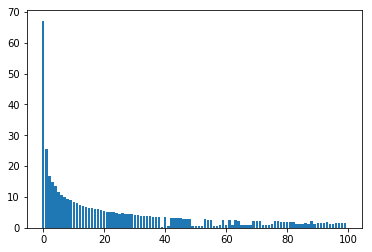

In [12]:
%matplotlib inline

import nltk 
from nltk.corpus import wordnet 
good = []
bad=  []

for word in pos_words:
    a = wordnet.synsets(word)
    if len(a)>0:
        syn = a[0] .lemmas()[0]
        if len(syn.antonyms())>0:
            good.append(word)
            bad.append(syn.antonyms()[0].name()) 
            
good_vectors=[]
bad_vectors = []
# good = ['good','beautiful','happy','positive','compentent','smart','interesting','pleasant','best','honest','wealthy','wonderful']
# bad = ['bad','ugly','sad','negative','incompetent','dumb','boring','horrible','worst','corrupt','poor','awful']
# good = ['amazing']
# bad = ['horrible']
choices = np.random.choice(len(good),20)
for i,j in zip(good,bad):
    if i in embeddings and j in embeddings:
        good_vectors.append(_np_normalize(embeddings[i]))
        bad_vectors.append(_np_normalize(embeddings[j]))

good_vectors = np.array(good_vectors)
bad_vectors = np.array(bad_vectors)
X = good_vectors-bad_vectors
m = np.dot(X.T,X)
evals, evecs = np.linalg.eig(m)
vec = _np_normalize(np.real(evecs[:, np.argmax(evals)]))
plt.bar(np.arange(100),evals[:100])

## create sentiment subspace via our method

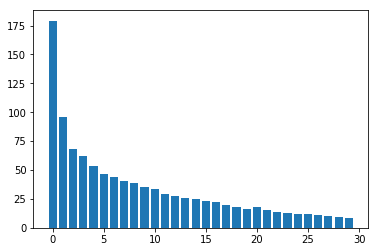

In [33]:
pos_vectors1=pos_vectors[np.random.choice(len(pos_vectors),50)]
m=np.dot(pos_vectors1.T,pos_vectors1)
evals, evecs = np.linalg.eig(m)
vec_pos = _np_normalize(np.real(evecs[:, np.argmax(evals)]))
fig = plt.figure()
plt.bar(np.arange(30),evals[:30])
fig.savefig('/home/csweeney/Downloads/glove_pos_s.png', format='png',dpi=300,bbox_inches='tight')

In [34]:
neg_vectors1=neg_vectors[np.random.choice(len(pos_vectors1),len(pos_vectors1))]

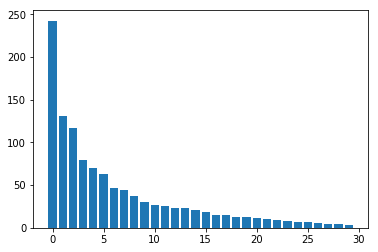

In [35]:
m=np.dot(neg_vectors1.T,neg_vectors1)
evals, evecs = np.linalg.eig(m)
vec_neg = _np_normalize(np.real(evecs[:, np.argmax(evals)]))
plt.figure()
plt.bar(np.arange(30),evals[:30])
fig.savefig('/home/csweeney/Downloads/glove_neg_s.png', format='png',dpi=300,bbox_inches='tight')

In [36]:
##get direcitonal sentiment vector
# vec=vec_pos-vec_neg
vec=(vec_pos-vec_neg)*-1

## Or load in the vector from the paper

In [7]:
#optionally read weights
import pickle
vec= np.array([])
with open('./best_toxic_vector.pkl', "rb") as openfile:
    while True:
        try:
            vec = pickle.load(openfile)
        except EOFError:
            break

## how does the sign of projection correlate with positive/negative labels

In [40]:
#sanity check
WORD = "great"
word_vec = _np_normalize(client.word_vec(WORD))
print vec.dot(word_vec.T)

-0.7322691


In [57]:
count = 0 
for i,j in zip(vectors,(targets*2-1)*-1):
    if int(np.sign(i.dot(vec))) == j:
        count+=1
print count/float(len(targets))

0.705191300206


In [58]:
MODEL_DIR = '../models/'
debias_model_name = 'wiki_debias_cnn_v3_{}'.format(109)
debias_model = ToxModel(debias_model_name,model_dir=MODEL_DIR)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 4
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
model_name: wiki_debias_cnn_v3_109
max_sequence_length: 250
stop_early: True
embedding_trainable: False



In [59]:
count = 0 
threshold = .5
for  index, (i,j) in enumerate(zip(vectors,(targets*2-1)*-1)):
    if (int(np.sign(i.dot(vec)))+1)/2 == (debias_model.predict([words_in_embeddings[index]])>=threshold):
        count+=1
print count/float(len(targets))

0.966502619463


In [50]:
#save weights
import pickle
with open('glove_vec.pkl', 'wb') as f:
    pickle.dump(vec, f)

## define set of identity terms

In [126]:
len(identities)

43

In [3]:
identities = ['lesbian', 'gay', 'bisexual', 'transgender', 'trans', 'queer', 
              'lgbt', 'lgbtq', 'homosexual', 'straight', 'heterosexual', 'male', 
              'female', 'nonbinary', 'african', 'african american', 'black', 'white', 
              'european', 'hispanic', 'latino', 'latina', 'latinx', 'mexican', 'canadian', 
              'american', 'asian', 'indian', 'middle eastern', 'chinese', 'japanese', 
              'christian', 'muslim', 'jewish', 'buddhist', 'catholic', 'protestant', 'sikh', 
              'taoist', 'old', 'older', 'young', 'younger', 'teenage', 'millenial', 'middle aged', 
              'elderly', 'blind', 'deaf', 'paralyzed']
identities = filter(lambda x: x in embeddings,identities)
nationalities=[
'German',
#'African_American',
'Mexican',
'Irish',
'English',
'American',
'Italian',
'Polish',
'French',
'Scottish',
#'Puerto_Rican',
'Norwegian',
'Dutch',
'Swedish',
'Chinese',
'Indian',
'Russian',
'Filipino'
]
religions =[ 
    'Zionist',
    'Catholic',
    'Christian',
    'Islamic',
    'Protestant',
#     'Taoist',
    'Atheist',
    'Hindu',
    'Buddhist',
#     'Diasporic',
    'Sikh',
#     'Juche',
    'Jewish',
#     'Bahai',
#     'Jains',
#     'Shinto',
#     'Pagan'
]
gender= ["male","female","her","him","man","woman","boy","girl","his","hers","mom","dad"]#perhaps try all terms intraprotected group

In [9]:
words = filter(lambda x: x.lower() in embeddings,religions)
df = pd.DataFrame(data={"word": list(words)})
df["sentiment_score"] = df["word"].map(
    lambda w: _np_normalize(embeddings[w.lower()]).dot(vec))
df.sort_values(by="sentiment_score", inplace=True)
print df

         word  sentiment_score
3     Islamic        -0.328052
1    Catholic        -0.293771
5     Atheist        -0.293575
0     Zionist        -0.291255
9      Jewish        -0.248637
6       Hindu        -0.234826
4  Protestant        -0.227194
2   Christian        -0.205779
7    Buddhist        -0.189258
8        Sikh        -0.045690


In [10]:
tf.reset_default_graph()
labels  = embeddings.syn0norm
protect=[]
for i in labels:
    protect.append(_np_normalize(i).dot(vec))
protect = np.expand_dims(np.array(protect),1)
print(" training on %s word vectors" % (np.shape(protect)[0]))

 training on 400000 word vectors


In [13]:
#bookeeping
w_h=[]
weights = [.5,1,2,4,8,16]
pairs = []
unbiased=[]

In [12]:
%%time
pred_learning_rate = 2**-16
protect_learning_rate = 2**-16
num_steps = 30000
batch_size = 1000

embed_dim = 100
projection_dims = 1


sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
with tf.variable_scope('var_scope', reuse=tf.AUTO_REUSE):
    for i in weights:
        print "weights", i
        protect_loss_weight = i

        labels_p = tf.placeholder(tf.float32, shape=[None, embed_dim], name="labels")
        protect_p = tf.placeholder(tf.float32, shape=[None, 1], name="protect")

        # projection is the space onto which we are "projecting". By default, this is
        # one-dimensional, but this can be tuned by projection_dims
        projection = tf.get_variable("projection", [embed_dim, projection_dims])

        # build the prediction layer
        pred = labels_p
        pred -= tf.matmul(tf.matmul(pred, projection), tf.transpose(projection))

        trained_model = AdversarialEmbeddingModel(
            client, embed_dim, projection, projection_dims, pred,verbose=True)
        trained_model.fit(sess, labels, labels_p, protect, protect_p, vec,
                  pred_learning_rate,
                protect_learning_rate, protect_loss_weight, num_steps, batch_size)
        w=None
        with sess.as_default(): w= trained_model.projection.eval()
        w_h.append(w)

weights 0.5
step: 0; pred_loss_o: 0.000273; protect_loss_o: 0.179202
proj_o: 1.341580; dot(proj_o, adv_direction): 0.214680)
step: 1000; pred_loss_o: 0.000306; protect_loss_o: 0.152206
proj_o: 1.346801; dot(proj_o, adv_direction): 0.306185)
step: 2000; pred_loss_o: 0.000444; protect_loss_o: 0.135685
proj_o: 1.380996; dot(proj_o, adv_direction): 0.398310)
step: 3000; pred_loss_o: 0.000669; protect_loss_o: 0.126068
proj_o: 1.424575; dot(proj_o, adv_direction): 0.492207)
step: 4000; pred_loss_o: 0.000977; protect_loss_o: 0.120912
proj_o: 1.472139; dot(proj_o, adv_direction): 0.585249)
step: 5000; pred_loss_o: 0.001376; protect_loss_o: 0.118283
proj_o: 1.522118; dot(proj_o, adv_direction): 0.679404)
step: 6000; pred_loss_o: 0.001867; protect_loss_o: 0.116287
proj_o: 1.573077; dot(proj_o, adv_direction): 0.766753)
step: 7000; pred_loss_o: 0.002439; protect_loss_o: 0.114122
proj_o: 1.618004; dot(proj_o, adv_direction): 0.838000)
step: 8000; pred_loss_o: 0.003093; protect_loss_o: 0.111287
pro

step: 10000; pred_loss_o: 0.005808; protect_loss_o: 0.122414
proj_o: 1.888876; dot(proj_o, adv_direction): -0.699328)
step: 11000; pred_loss_o: 0.006241; protect_loss_o: 0.113755
proj_o: 1.893580; dot(proj_o, adv_direction): -0.730459)
step: 12000; pred_loss_o: 0.006493; protect_loss_o: 0.105676
proj_o: 1.885883; dot(proj_o, adv_direction): -0.752180)
step: 13000; pred_loss_o: 0.006595; protect_loss_o: 0.097919
proj_o: 1.867950; dot(proj_o, adv_direction): -0.767900)
step: 14000; pred_loss_o: 0.006575; protect_loss_o: 0.090801
proj_o: 1.837814; dot(proj_o, adv_direction): -0.784100)
step: 15000; pred_loss_o: 0.006502; protect_loss_o: 0.085088
proj_o: 1.798852; dot(proj_o, adv_direction): -0.802586)
step: 16000; pred_loss_o: 0.006418; protect_loss_o: 0.080207
proj_o: 1.758888; dot(proj_o, adv_direction): -0.822811)
step: 17000; pred_loss_o: 0.006361; protect_loss_o: 0.075779
proj_o: 1.723005; dot(proj_o, adv_direction): -0.842615)
step: 18000; pred_loss_o: 0.006194; protect_loss_o: 0.07

step: 20000; pred_loss_o: 0.007805; protect_loss_o: 0.074149
proj_o: 1.677633; dot(proj_o, adv_direction): -0.957317)
step: 21000; pred_loss_o: 0.007027; protect_loss_o: 0.075007
proj_o: 1.628019; dot(proj_o, adv_direction): -0.941487)
step: 22000; pred_loss_o: 0.006233; protect_loss_o: 0.075765
proj_o: 1.575136; dot(proj_o, adv_direction): -0.931821)
step: 23000; pred_loss_o: 0.005548; protect_loss_o: 0.076049
proj_o: 1.524040; dot(proj_o, adv_direction): -0.924496)
step: 24000; pred_loss_o: 0.004949; protect_loss_o: 0.076346
proj_o: 1.475638; dot(proj_o, adv_direction): -0.927834)
step: 25000; pred_loss_o: 0.004499; protect_loss_o: 0.077308
proj_o: 1.434443; dot(proj_o, adv_direction): -0.946685)
step: 26000; pred_loss_o: 0.004209; protect_loss_o: 0.079170
proj_o: 1.403169; dot(proj_o, adv_direction): -0.976775)
step: 27000; pred_loss_o: 0.004089; protect_loss_o: 0.082483
proj_o: 1.382815; dot(proj_o, adv_direction): -1.001027)
step: 28000; pred_loss_o: 0.004020; protect_loss_o: 0.08

In [5]:
#optionally read weights
import pickle
p = None
with (open('./toxic_weights.pkl', "rb")) as openfile:
    while True:
        try:
            p=pickle.load(openfile)
        except EOFError:
            break
w_h = p

In [18]:
for j in [identities]: 
    words = j
    a=map(lambda a: _np_normalize(embeddings[a.lower()]).dot(vec),words)
    s1 = np.sum(np.abs(np.array(a)))
    print(s1)
    unbiased.append(s1)
    s2= evaluate_word_pairs(model=embeddings,pairs="../data/sim/sim.tsv",restrict_vocab=2000000,debias=lambda x :x)
    print(s2)
    pairs.append(s2)
    for w in w_h:
            a=map(lambda a: (_np_normalize(embeddings[a.lower()])-(np.dot(np.dot(w,w.T),_np_normalize(embeddings[a.lower()])))).dot(vec),words)
            s = np.sum(np.abs(np.array(a)))
            print(s)
            unbiased.append(s)
            
            s2= evaluate_word_pairs(model=embeddings,pairs="../data/sim/sim.tsv",restrict_vocab=2000000,debias=lambda x :(x-(np.dot(np.dot(w,w.T),x))))
            print(s2)
            pairs.append(s2)

17.448019
((0.6238773451304681, 1.7963247628700625e-39), SpearmanrResult(correlation=0.6589215888009288, pvalue=2.5346056459149263e-45), 0.0)
7.464306
((0.6224447658866008, 3.00504083024793e-39), SpearmanrResult(correlation=0.65184927232812, pvalue=4.437628061417715e-44), 0.0)
8.019999
((0.623062490972614, 2.4078786460808566e-39), SpearmanrResult(correlation=0.6546950043136879, pvalue=1.4155220846120511e-44), 0.0)
8.006304
((0.623960908887512, 1.7430669996765395e-39), SpearmanrResult(correlation=0.6543636706451544, pvalue=1.6179680577963702e-44), 0.0)
7.5407305
((0.6214944487717432, 4.221348343255321e-39), SpearmanrResult(correlation=0.6512557635624597, pvalue=5.623076240070313e-44), 0.0)
7.51387
((0.6218769851358951, 3.6821168467631286e-39), SpearmanrResult(correlation=0.6504858799785969, pvalue=7.638539838545728e-44), 0.0)
9.049315
((0.6224870125543401, 2.959899436796696e-39), SpearmanrResult(correlation=0.6527206430463546, pvalue=3.1316310216308743e-44), 0.0)


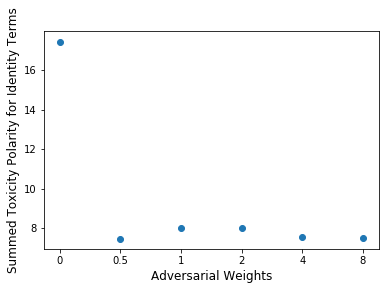

In [34]:
fig = plt.figure()
plt.scatter(np.arange(len(weights)),unbiased[:-1])
plt.xticks(np.arange(len(weights)),[0]+weights[:-1])
plt.xlabel("Adversarial Weights",fontsize=12)
plt.ylabel("Summed Toxicity Polarity for Identity Terms",fontsize=12)
fig.savefig('/home/csweeney/Downloads/glove_bb.png', format='png',dpi=300,bbox_inches='tight')
# plt.ylim(,.8)

In [44]:
np.arange(len(weights)),pairs[:-1]

(array([0, 1, 2, 3, 4, 5]),
 [((0.6238773451304681, 1.7963247628700625e-39),
   SpearmanrResult(correlation=0.6589215888009288, pvalue=2.5346056459149263e-45),
   0.0),
  ((0.6224447658866008, 3.00504083024793e-39),
   SpearmanrResult(correlation=0.65184927232812, pvalue=4.437628061417715e-44),
   0.0),
  ((0.623062490972614, 2.4078786460808566e-39),
   SpearmanrResult(correlation=0.6546950043136879, pvalue=1.4155220846120511e-44),
   0.0),
  ((0.623960908887512, 1.7430669996765395e-39),
   SpearmanrResult(correlation=0.6543636706451544, pvalue=1.6179680577963702e-44),
   0.0),
  ((0.6214944487717432, 4.221348343255321e-39),
   SpearmanrResult(correlation=0.6512557635624597, pvalue=5.623076240070313e-44),
   0.0),
  ((0.6218769851358951, 3.6821168467631286e-39),
   SpearmanrResult(correlation=0.6504858799785969, pvalue=7.638539838545728e-44),
   0.0)])

ValueError: x and y must be the same size

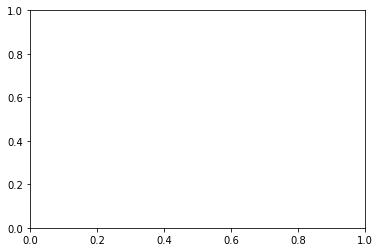

In [46]:
fig = plt.figure()
plt.scatter(np.arange(len(weights)),pairs[:-1])
plt.xticks(np.arange(len(weights)),[0]+weights[:-1])
plt.xlabel("Adversarial Weights",fontsize=12)
plt.ylabel("WordSim353 Similarity Spearman Correlation",fontsize=12)
fig.savefig('/home/csweeney/Downloads/glove_bb.png', format='png',dpi=300,bbox_inches='tight')
# plt.ylim(,.8)

In [35]:
# #save weights
# import pickle
# with open('toxic_weights_glove.pkl', 'wb') as f:
#     pickle.dump(w_h, f)

## Rembed seleceted word and save model

In [47]:
glove_input_file = '../data/glove.6B/glove.6B.100d.txt'
word2vec_output_file = '../data/glove.6B/glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
embeddings_debias = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file,binary=False)

NameError: name 'glove2word2vec' is not defined

In [34]:
w = w_h[0]
for i in identities:
    if i.lower() in embeddings_debias:
        embeddings_debias.wv.syn0[embeddings_debias.wv.vocab[i.lower()].index] = _np_normalize(embeddings_debias[i])-(np.dot(np.dot(w,w.T),_np_normalize(embeddings_debias[i])))
embeddings_debias.wv.syn0norm = None
embeddings_debias.wv.init_sims()
embeddings_debias.save_word2vec_format("glove_debias_new_toxic.txt", binary=False)

In [25]:
embeddings = gensim.models.KeyedVectors.load_word2vec_format('detoxified_word2vec_embeddings.txt',binary=False,limit=13000)

In [26]:
embeddings.save_word2vec_format("detoxified_word2vec_embeddings_light.txt", binary=False)

## Evaluate Word Embeddings before and after debiasing

In [19]:
w = w_h[0]

In [20]:
client.similar_by_vector(_np_normalize(embeddings['male']))

[(u'male', 1.0000001192092896),
 (u'female', 0.8405333161354065),
 (u'males', 0.7579617500305176),
 (u'females', 0.7030534744262695),
 (u'accomplice_Hudgens', 0.6375256776809692),
 (u'Male', 0.6288970112800598),
 (u'Female', 0.5971192121505737),
 (u'femal', 0.5850157737731934),
 (u'Caucasian_males', 0.5570127367973328),
 (u'masculinised', 0.5340930223464966)]

In [21]:
client.similar_by_vector(_np_normalize(embeddings['male']))

[(u'male', 1.0000001192092896),
 (u'female', 0.8405333161354065),
 (u'males', 0.7579617500305176),
 (u'females', 0.7030534744262695),
 (u'accomplice_Hudgens', 0.6375256776809692),
 (u'Male', 0.6288970112800598),
 (u'Female', 0.5971192121505737),
 (u'femal', 0.5850157737731934),
 (u'Caucasian_males', 0.5570127367973328),
 (u'masculinised', 0.5340930223464966)]

In [22]:
client.similar_by_vector(_np_normalize(embeddings['male'])-np.dot(np.dot(w,w.T),_np_normalize(embeddings['male'])))

[(u'male', 0.9783856272697449),
 (u'female', 0.8173885941505432),
 (u'males', 0.7334728837013245),
 (u'females', 0.6692583560943604),
 (u'Male', 0.60198974609375),
 (u'Female', 0.5653233528137207),
 (u'femal', 0.5433569550514221),
 (u'Caucasian_males', 0.5221525430679321),
 (u'accomplice_Hudgens', 0.5165694952011108),
 (u'heterosexual_males', 0.4910895824432373)]

In [23]:
words= filter(lambda x: x.lower() in embeddings,identities)

summed toxiity polarity:  17.448019


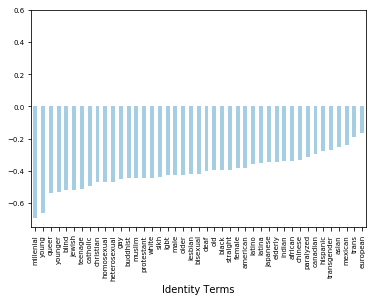

In [24]:
%matplotlib inline

df1 = pd.DataFrame(data={"Identity Terms": list(words)})
df1["sentiment polarity"] = df1["Identity Terms"].map(
        lambda a: (_np_normalize(embeddings[a.lower()]).dot(vec)))
df1.sort_values(by="sentiment polarity", inplace=True)
# fig = plt.figure() 
# fig.set_size_inches(18.5, 10.5)
fig = df1.plot.bar(legend = False, ylim= (-.75,.6),x="Identity Terms",y="sentiment polarity",fontsize=7, colormap='Paired')
#     plt.xlabel('Identity Terms', fontsize=14)
#     plt.ylabel('<--- more toxic less toxic --->', fontsize=14)
#     plt.title("National Origin Toxicity Polarity",fontsize= 15)
a=map(lambda a: (_np_normalize(embeddings[a.lower()])).dot(vec),words)
print "summed toxiity polarity: ", np.sum(np.abs(np.array(a)))
plt.draw()
fig.get_figure().savefig('/home/csweeney/Downloads/glovebiased.png', format='png',dpi=300,bbox_inches='tight')


In [25]:
words= df1["Identity Terms"].values

summed toxiity polarity:  7.464306


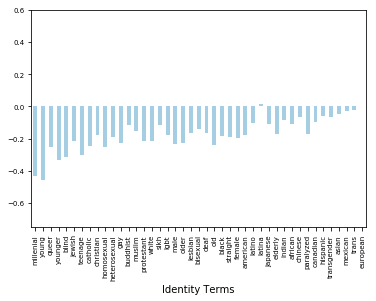

In [26]:
%matplotlib inline
df = pd.DataFrame(data={"Identity Terms": list(words)})
df["sentiment polarity"] = df["Identity Terms"].map(
        lambda a: (_np_normalize(embeddings[a.lower()])-(np.dot(np.dot(w,w.T),_np_normalize(embeddings[a.lower()])))).dot(vec))
#     df.sort_values(by="sentiment polarity", inplace=True)
# plt.figure()
fig = df.plot.bar(legend = False, ylim= (-.75,.6),x="Identity Terms",y="sentiment polarity",fontsize=7, colormap='Paired')
# plt.xlabel('Identity Terms', fontsize=14)
# plt.ylabel('sentiment polarity', fontsize=14)
# plt.title("Debiased National Origin Sentiment Polarity",fontsize= 15)
a=map(lambda a: (_np_normalize(embeddings[a.lower()])-(np.dot(np.dot(w,w.T),_np_normalize(embeddings[a.lower()])))).dot(vec),words)
print "summed toxiity polarity: ", np.sum(np.abs(np.array(a)))
fig.get_figure().savefig('/home/csweeney/Downloads/gloveunbiased.png', format='png',dpi=300,bbox_inches='tight')

(-0.6, 0.6)

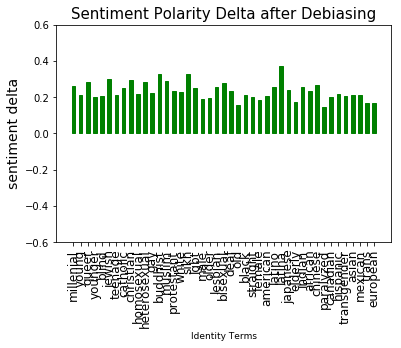

In [27]:
plt.figure()
plt.xlabel('Identity Terms', fontsize=9)
plt.ylabel('sentiment delta', fontsize=14)
plt.title("Sentiment Polarity Delta after Debiasing",fontsize= 15)
index = np.arange(len(words))
delta = df["sentiment polarity"].values-df1["sentiment polarity"].values
bar = plt.bar(index,delta,width=.5)
for i,j in enumerate(delta):
    bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, words, fontsize=12, rotation=90)
plt.ylim(top=.6,bottom=-.6)

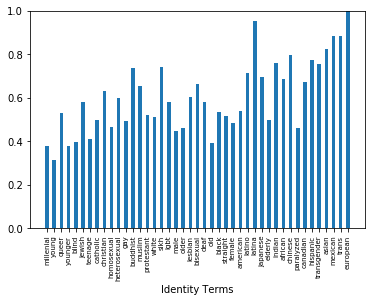

In [28]:
fig = plt.figure()
plt.xlabel('Identity Terms', fontsize=10)
# plt.ylabel('Relative Sentiment Polarity', fontsize=14)
# plt.title("Relative Sentiment Polarity Removed after Debiasing",fontsize= 15)
index = np.arange(len(words))
delta = np.abs(df1["sentiment polarity"].values)-np.abs(df["sentiment polarity"].values)
plt.bar(index,delta/np.abs(df1["sentiment polarity"].values),width=.5)
# plt.bar(index,df["sentiment polarity"].values,width=.5)
# for i,j in enumerate(delta):
#     bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, words, fontsize=7, rotation=90)
plt.ylim(top=1,bottom=0)
fig.savefig('/home/csweeney/Downloads/rebiased.png', format='png',dpi=300,bbox_inches='tight')


In [122]:
np.sum(delta/np.abs(df1["sentiment polarity"].values))/len(delta)

0.2646858533362516

## evaluate gender toxicity/negative sentiment distributions

In [209]:
import seaborn
# name_occurence.sort_values(ascending=True,by="toxicity")
male = ["male","him","man","boy","his","father","dad","men"]
female= ["female","her","woman","girl","hers","mother","mom","women"]

<IPython.core.display.Javascript object>


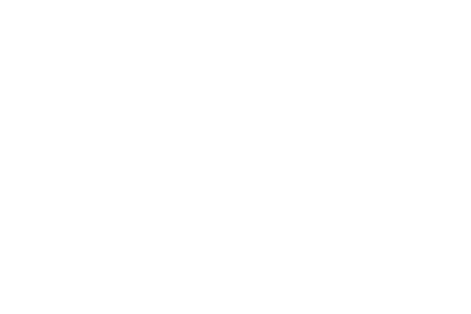

(-0.15, 0.2)

<IPython.core.display.Javascript object>


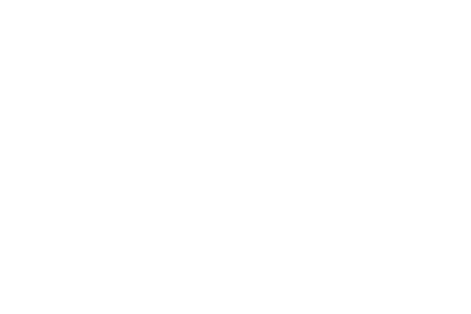

In [210]:
seaborn.set(font_scale=1.5)
frames = []
df = pd.DataFrame(data={"Identity Terms": list(male)})
df["sentiment polarity"] = df["Identity Terms"].map(
        lambda a: (embeddings[a.lower()]-(np.dot(np.dot(w,w.T),embeddings[a.lower()]))).dot(vec))
# toxicity = pd.DataFrame({'sentiment polarity': toxicities}, index=male)
df['group'] = "male"
frames.append(df)
df_g = pd.DataFrame(data={"Identity Terms": list(female)})
df_g["sentiment polarity"] = df_g["Identity Terms"].map(
        lambda a: (embeddings[a.lower()]-(np.dot(np.dot(w,w.T),embeddings[a.lower()]))).dot(vec))
# toxicity = pd.DataFrame({'sentiment polarity': toxicities}, index=male)
df_g['group'] = "female"
frames.append(df_g)

o = pd.concat(frames)
%matplotlib nbagg
plot = seaborn.swarmplot(x='group', y="sentiment polarity", data=o)
plot.set_ylim([-.15, .2])


<IPython.core.display.Javascript object>


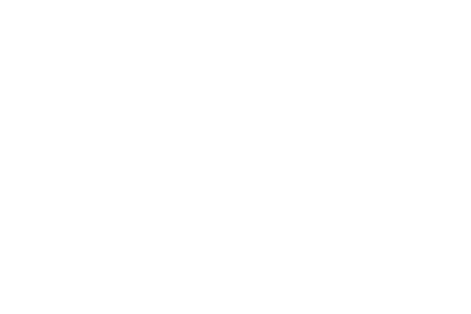

(-0.2, 0.1)

<IPython.core.display.Javascript object>


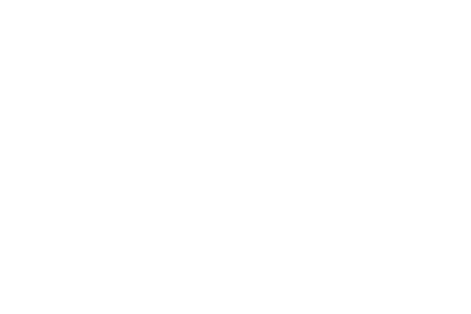

In [211]:
seaborn.set(font_scale=1.5)
frames = []
df = pd.DataFrame(data={"Identity Terms": list(male)})
df["sentiment polarity"] = df["Identity Terms"].map(
        lambda a: (embeddings[a.lower()].dot(vec)))
# toxicity = pd.DataFrame({'sentiment polarity': toxicities}, index=male)
df['group'] = "male"
frames.append(df)
df_g = pd.DataFrame(data={"Identity Terms": list(female)})
df_g["sentiment polarity"] = df_g["Identity Terms"].map(
        lambda a: (embeddings[a.lower()].dot(vec)))
# toxicity = pd.DataFrame({'sentiment polarity': toxicities}, index=male)
df_g['group'] = "female"
frames.append(df_g)

o = pd.concat(frames)
%matplotlib nbagg
plot = seaborn.swarmplot(x='group', y="sentiment polarity", data=o)
plot.set_ylim([-.2, .1])

0.20355020222002063
0.2775666800500944


<IPython.core.display.Javascript object>


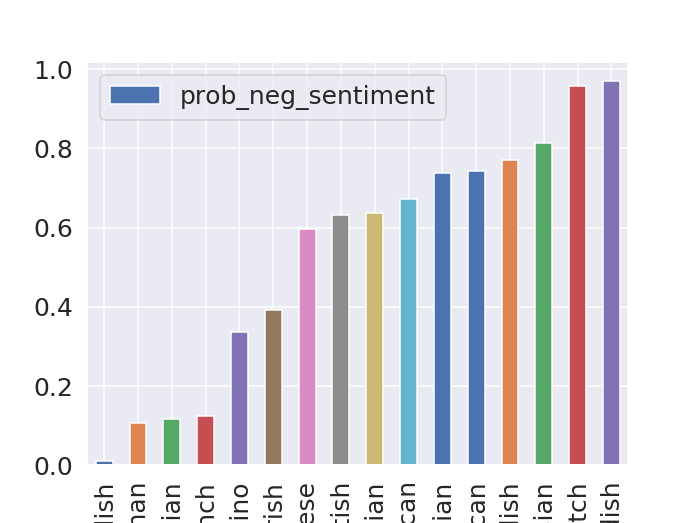

In [74]:
df = pd.DataFrame(data = {"word": list(words)})
df["prob_neg_sentiment"] = df["word"].map(
    lambda w: clf.predict_proba([embeddings[w.lower()]])[0][1])
df.sort_values(by="prob_neg_sentiment", inplace=True)
a= list(df["prob_neg_sentiment"])
uniform_dist = np.ones(len(a))*1./len(a)
normalized = a/np.sum(a)
kl = (normalized * np.log(normalized/uniform_dist)).sum()
print kl
print np.sum(np.abs(np.array(a)-.5))/len(a)
df.plot.bar(x="word",y="prob_neg_sentiment")


0.20318198136483467
0.27726869360041706


<IPython.core.display.Javascript object>


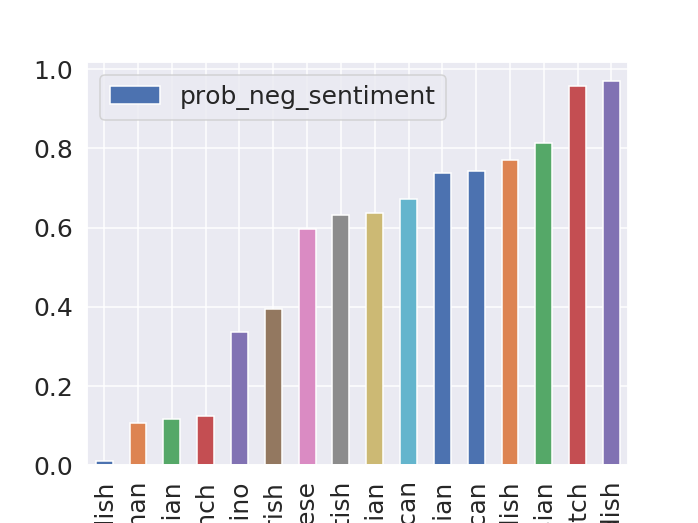

In [75]:
df = pd.DataFrame(data = {"word": list(words)})
df["prob_neg_sentiment"] = df["word"].map(
    lambda a: clf.predict_proba([(embeddings[a.lower()]-np.dot(np.dot(w,w.T),embeddings[a.lower()]))])[0][1])
df.sort_values(by="prob_neg_sentiment", inplace=True)
a= list(df["prob_neg_sentiment"])
uniform_dist = np.ones(len(a))*1./len(a)
normalized = a/np.sum(a)
kl = (normalized * np.log(normalized/uniform_dist)).sum()
print kl
print np.sum(np.abs(np.array(a)-.5))/len(a)

df.plot.bar(x="word",y="prob_neg_sentiment")

## test wordsim accruacy on debiased word embeddings

In [69]:
evaluate_word_pairs(model=embeddings,pairs="../data/sim/sim.tsv",restrict_vocab=2000000,debias=lambda x :x)

((0.6238773451304681, 1.7963247628700625e-39),
 SpearmanrResult(correlation=0.6589215888009288, pvalue=2.5346056459149263e-45),
 0.0)

## test analogy accruacy on debiased word embeddings

In [70]:
(X,y,l) = load_vectors_test(embeddings,analogies)
analogy_accuracy(X,l,embeddings,n = 1,samples=100,model=lambda x :(x-(np.dot(np.dot(w,w.T),x))))

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


0.21